## Import all required libraries

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

In [3]:
# REGIONAL CO2 STORAGE POTENTIAL
# read storage potential in GtCO2
potentials = pd.read_excel("storage_by_country.xlsx").set_index("ISO")

# read regional country lists
reg_list_path = "region_code_list.yaml"

with open(reg_list_path, 'r') as file:
    reg_data = yaml.safe_load(file)

# creating R12 potentials dataframe
R12_potential = pd.DataFrame(columns=["Potential"])

for reg in set(reg_data.keys()) - {"World"}:
    val = potentials.loc[reg_data[reg]["child"]]["Potential"].sum()
    R12_potential.loc[reg] = np.round(1000*val/3.667, 3) # convert to MtCO2
    
R12_pot = R12_potential.div(90)

In [4]:
R12_potential

,Potential
R12_PAS,21108.578
R12_LAM,55868.988
R12_MEA,57369.171
R12_PAO,34233.825
R12_FSU,83310.661
R12_WEU,11793.358
R12_SAS,4765.219
R12_EEU,1808.370
R12_CHN,15712.475
R12_NAM,58983.981


In [5]:
R12_potential.sum()

Potential    410108.133
dtype: float64

In [6]:
R12_pot

,Potential
R12_PAS,234.539756
R12_LAM,620.766533
R12_MEA,637.435233
R12_PAO,380.375833
R12_FSU,925.674011
R12_WEU,131.037311
R12_SAS,52.946878
R12_EEU,20.093000
R12_CHN,174.583056
R12_NAM,655.377567


In [7]:
# SSPs and scenarios lists
ssps = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
ssps = ["SSP1","SSP2","SSP5"]
# Parameters for CO2 injection rate scenarios
co2rates = {
    "co2rate1": 0.2,
    "co2rate2": 0.4,
    "co2rate3": 0.6,
    "co2rate4": 0.8,
    "co2rate5": 1.0,
        }
              
max_rate = np.round(15000/3.667,0) # convert MtCO2/y to MtC/y

# Parameters for DAC market penetration rate scenarios
mpens = {
    "mpen1": 0.050,
    "mpen2": 0.075,
    "mpen3": 0.100,
    "mpen4": 0.125,
    "mpen5": 0.150,
        }

# Parameters for CO2 storage availability scenarios
stors = {
    "stor1": 0.2,
    "stor2": 0.4,
    "stor3": 0.6,
    "stor4": 0.8,
    "stor5": 1.0,
        }

maxfco2storshares = {
    "maxfco2storshare1": 1.00, # max
    "maxfco2storshare2": 0.80, # max
    "maxfco2storshare3": 0.60, # max
    "maxfco2storshare4": 0.40, # max
    "maxfco2storshare5": 0.20, # max
}

minfco2storshares = {
    "minfco2storshare1": 0.10, # min
    "minfco2storshare2": 0.20, # min
    "minfco2storshare3": 0.30, # min
    "minfco2storshare4": 0.40, # min
    "minfco2storshare5": 0.50, # min
}

daccosts ={
    "daccost1":[1.00,0.97,0.96,0.94,0.93,0.92,0.91,0.91,0.90,0.90,0.90,0.90,0.90],
    "daccost2":[1.00,0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
    "daccost3":[1.00,0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
    "daccost4":[1.00,0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
    "daccost5":[1.00,0.77,0.61,0.46,0.36,0.27,0.22,0.16,0.13,0.11,0.11,0.10,0.10],
}

dacenergies ={
    "dacener1":[1.00,0.97,0.96,0.94,0.93,0.92,0.91,0.91,0.90,0.90,0.90,0.90,0.90],
    "dacener2":[1.00,0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
    "dacener3":[1.00,0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
    "dacener4":[1.00,0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
    "dacener5":[1.00,0.77,0.61,0.46,0.36,0.27,0.22,0.16,0.13,0.11,0.11,0.10,0.10],
}



## Create baseline and emission bound scenarios with split CO2 infrastructure

# Run market penetration `mpen` scenarios

# Run CO$_2$ storage scenarios <<<<<<<<<<<<<<<<<<<<<<<<<<<

# Run CO$_2$ injection rates scenarios

# Run max fossil CO$_2$ storage share scenarios

# Run min fossil CO$_2$ storage share scenarios

# Run DAC cost scenarios

# Run DAC energy scenarios

# With DAC scenarios

## All SSP parameters

## All SSPs with 50% min. CCS storage share

SSP1 objective value: 2457709.0
stor scenario: SSP1


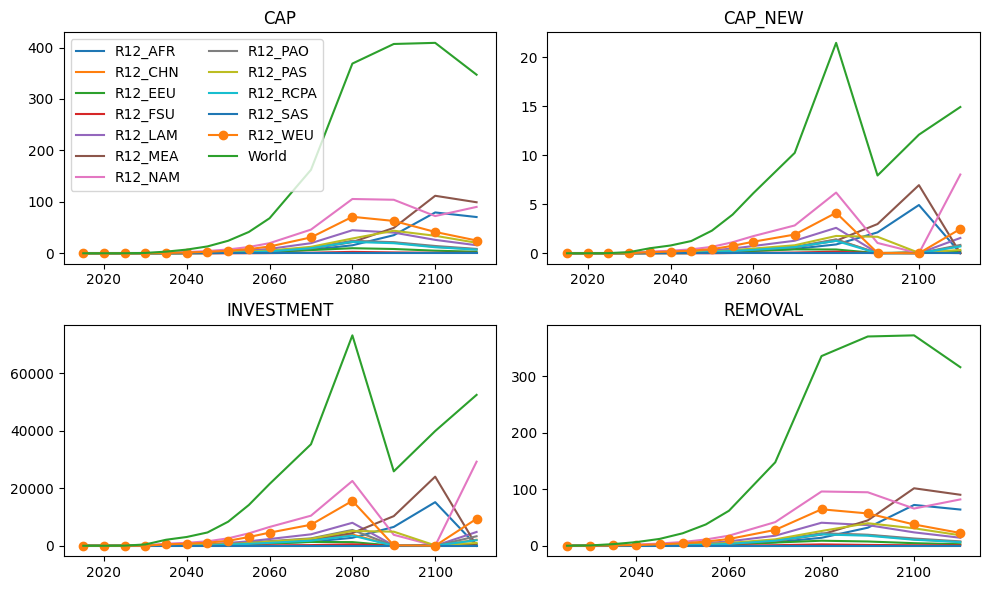

SSP2 objective value: 2742546.5
stor scenario: SSP2


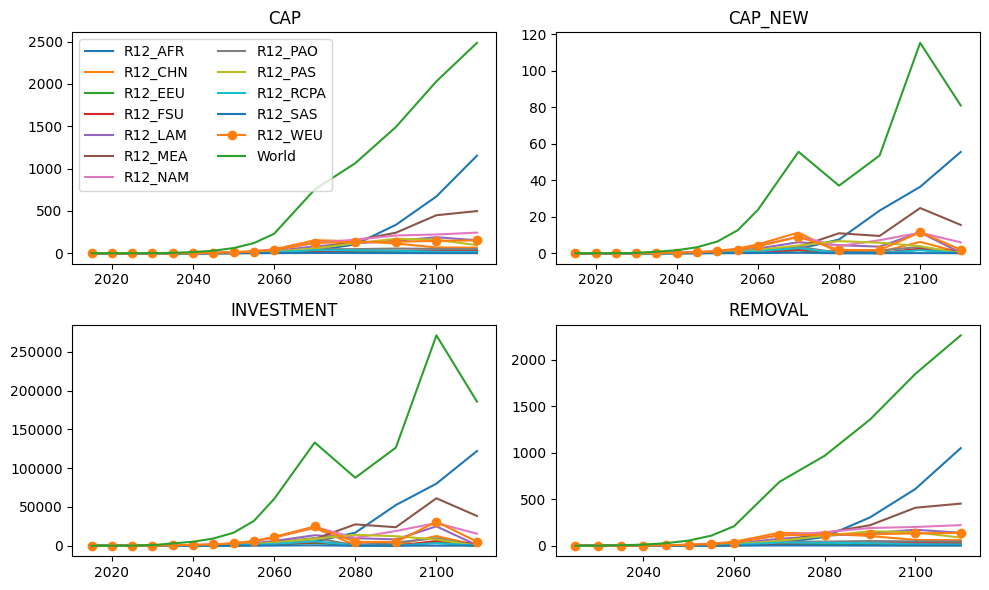

SSP5 objective value: 3374428.0
stor scenario: SSP5


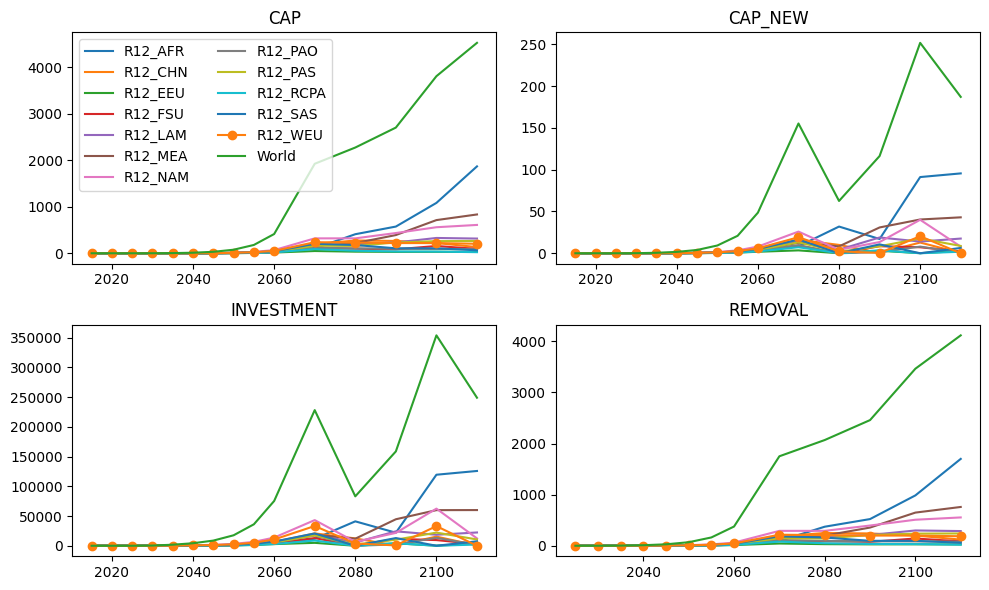

In [8]:
parameters = {
           # min  max 
    "SSP1": [0.5, 1.0],
    "SSP2": [0.5, 1.0],
    "SSP5": [0.5, 1.0],
    }

mp = ixmp.Platform()

for ssp in parameters.keys():
#for ssp in ["SSP5"]:
    sbase = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', 
                                scenario="1000f_v0.14_dac-co2split_all-ssp-param")
    s2run = sbase.clone(
        f"SSP_dev_{ssp}_v0.1_dac",
        f"1000f_v0.14_dac-co2split_min-fco2-share",
        f"{ssp}_dev 1000f carbon budget with all SSP-specific parameter",
        keep_solution=False, 
    )
    s2run.check_out()
    
    
    
    # Updating Min FCO2 share
    ## creating lower and upper bound dataframes
    df2rem = s2run.par("share_mode_lo",
                       {
                           "shares":"fco2storshare",
                           "technology":"co2_storcumulative",
                           "mode":"M1",
                           "year_act":2100,
                       }
                      )
    df2add = df2rem.copy()
    df2add["value"] = parameters[ssp][0]
    
    s2run.remove_par("share_mode_lo", df2rem)
    s2run.add_par("share_mode_lo", df2add)

    # Updating Max FCO2 share
    ## creating lower and upper bound dataframes
    df2rem = s2run.par("share_mode_up",
                       {
                           "shares":"fco2storshare",
                           "technology":"co2_storcumulative",
                           "mode":"M1",
                           "year_act":2100,
                       }
                      )
    df2add = df2rem.copy()
    df2add["value"] = parameters[ssp][1]
    
    s2run.remove_par("share_mode_up", df2rem)
    s2run.add_par("share_mode_up", df2add)
    
    
    # commit and run
    s2run.commit(comment=f"{ssp}_dev 1000f with DAC and all SSP-specific parameters")
    s2run.set_as_default()

    s2run.solve(solve_options={'barcrossalg': '2','scaind': '0'})
    print(ssp, "objective value:", s2run.var("OBJ")["lvl"])

    # Get Report
    print("stor scenario:", ssp)
    scenariotec = ['dac_lt','dac_ht']
    scenario_report = get_report(s2run,scenariotec)
            
# CLOSE CONNECTION
mp.close_db()




## All SSPs without min. CCS storage share

# Without DAC

## All SSPs parameters 

SSP1 objective value: 2459480.0
stor scenario: SSP1


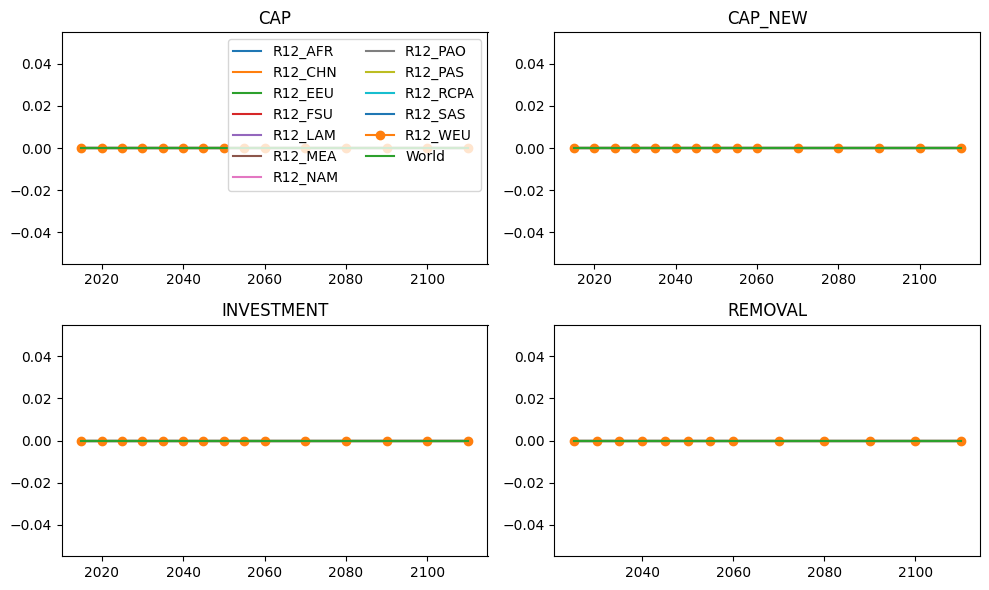

SSP2 objective value: 2739519.5
stor scenario: SSP2


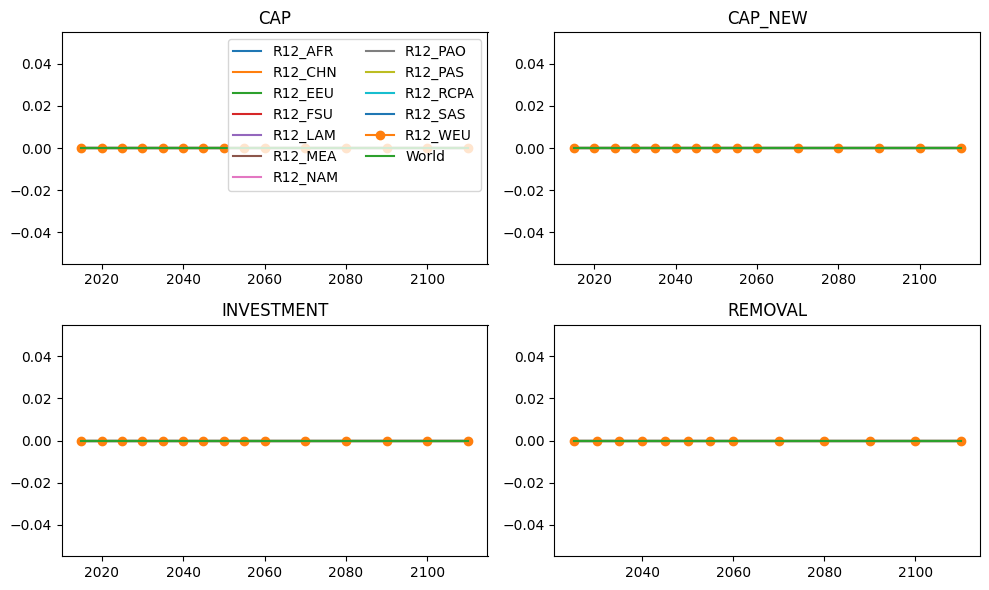

SSP5 objective value: 3388967.0
stor scenario: SSP5


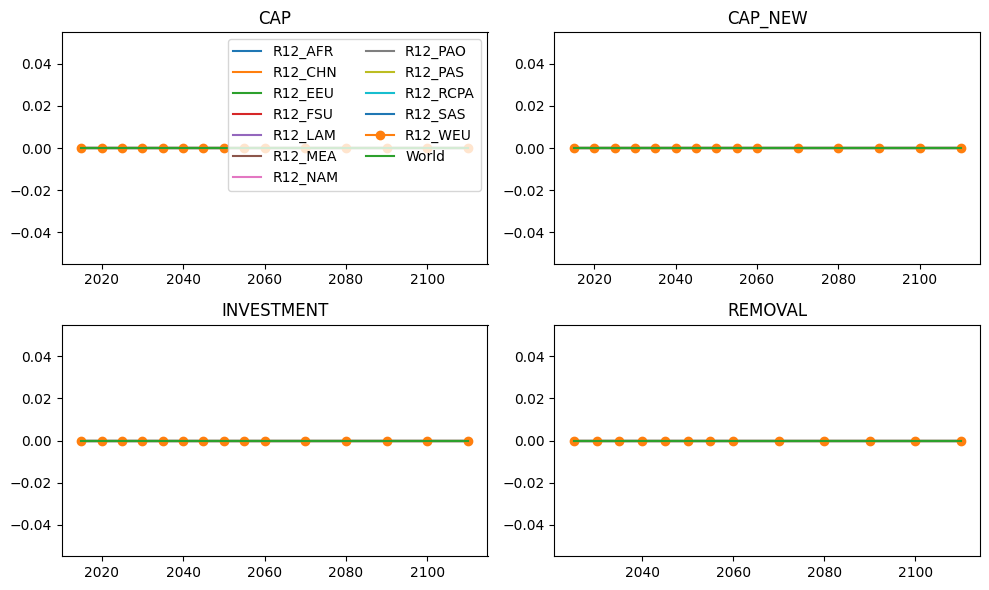

In [9]:
parameters = {
    "SSP1": 0.0,
    "SSP2": 0.0,
    "SSP5": 0.0,
    }

mp = ixmp.Platform()


for ssp in parameters.keys():
#for ssp in ["SSP5"]:
    sbase = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', 
                                scenario="1000f_v0.14_dac-co2split_all-ssp-param")
    s2run = sbase.clone(
        f"SSP_dev_{ssp}_v0.1_dac",
        f"1000f_v0.14_dac-co2split_no-dac",
        f"{ssp}_dev 1000f carbon budget with all SSP-specific parameter",
        keep_solution=False, 
    )
    s2run.check_out()
    
    
    
    # Updating market penetration parameters
    parnames = ["growth_activity_up","soft_activity_up","initial_activity_up"]
    for name in parnames:
        df2rem = s2run.par(name, {"technology":"DAC_mpen"})
        df2add = df2rem.copy()
        df2add["value"] = parameters[ssp]

        s2run.remove_par(name, df2rem)
        s2run.add_par(name, df2add)

    
    
    # commit and run
    s2run.commit(comment=f"{ssp}_dev 1000f with DAC and all SSP-specific parameters")
    s2run.set_as_default()

    s2run.solve(solve_options={'barcrossalg': '2','scaind': '0'})
    print(ssp, "objective value:", s2run.var("OBJ")["lvl"])

    # Get Report
    print("stor scenario:", ssp)
    scenariotec = ['dac_lt','dac_ht']
    scenario_report = get_report(s2run,scenariotec)
            
# CLOSE CONNECTION
mp.close_db()




## All SSPs with 50% min. CO2 storage share 

## All SSPs without min. CCS storage share

# All SSPs sensitivities

## CO2 Rates

## DAC energies

## DAC costs <<<<<<<<<<<<<<<<<<

## DAC Scaleup rates

# CO2 storage scenarios

# Tests